## Comparison of GloGEM, PyGEM, and OGGM RGI 17 Volume Outputs 

This notebook imports and processes GloGEM, PyGEM, and OGGM RGI 08 volume outpts. Summing glacial volume change by basin, we produce a plot that compares the three models' projected volume values for each basin by SSP. 

Last Updated: 7 Dec 2023 | FFW

## Loading in data:

### GloGEM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import os

## Generic the filepath to the main data folder
fpath0 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/'
fpath1 = 'Runoff-intercomparison/GloGEM-output/Volume_GloGEM-20230626' 

#All of the climate models used
modelnames_glo = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #Use a different path as we have all 5 ssps for volume

In [3]:
volumes = {}
for s, SSP in enumerate(SSPs):
    volumes[SSP] = {}
    for m, model in enumerate(modelnames_glo):
        temp_df = pd.read_csv(fpath0 + fpath1 +'/SouthernAndes/' + model + '/' + SSP  + '/' + 'Volume_SouthernAndes.dat', sep='\s+', header=None, skiprows=1, index_col=0)
        # Ensure all indices are same length
        temp_df.index = temp_df.index.map(lambda x: str(x).zfill(5))
        temp_df.index = '17.' + temp_df.index.astype(str)   #Specifying region--need to do for cross region sum
        volumes[SSP][model] = temp_df

In [4]:
# Create new index using pandas date_range function
start_date = datetime.date(1980, 1, 1)
end_date = datetime.date(2101, 12, 1)
new_indices = pd.date_range(start_date, end_date, freq='A').strftime('%Y-%m').tolist()

# Apply new index and datetime conversion
for s, SSP in enumerate(SSPs):
    for m, model in enumerate(modelnames_glo):
        volumes[SSP][model].columns = new_indices
        volumes[SSP][model].columns = pd.to_datetime(new_indices)

In [5]:
import json
def select_glaciers_json(basin='all'):
    '''
    Select glaciers within a basin by MRBID from a json-file,
    which is stored in the data directory.

    Args:
    -----
    basin: str
        String of MRBID or 'all'.

    Returns:
    --------
    If basin is 'all' a list of all relevant glaciers is returned, for
    initiating glacier simulations. If basin is a MRBID the list of glaciers
    within that basin is returned.
    
    Copy of a function written by Erik Holmgren (2022) in holmgren_gha.utils
    '''

    # fpath = './data/rgi_ids_per_basin.json'
    fpath = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/rgi_ids_per_basin.json'  
    with open(fpath) as f:
        basin_dict = json.load(f)

    if basin.lower() != 'all':
        glacier_list = basin_dict[basin]
    else:
        glacier_list = list(itertools.chain.from_iterable(basin_dict.values()))

    return glacier_list

In [6]:
def sum_basin(basin_RGI_list, volume_data):
    # Create new list to match our RGI formatting
    new_basin_list = [str(x)[-8:] for x in basin_RGI_list]
    #runoff_data = runoff_data.transpose()
    
    #TODO: create list of glaciers within a basin that are not included in GloGEM output
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_basin_list = [x for x in new_basin_list if x in volume_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = volume_data.loc[new_basin_list].copy()
    
    # Sum the values of the glaciers within the basin
    summed_basin_runoff = new_df.sum()
    #print(summed_basin_runoff)
    
    return summed_basin_runoff

In [7]:
Alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

basin_sums_glo = {}
for s, SSP in enumerate(SSPs):
    basin_sums_glo[SSP] = {}
    for b, basin in enumerate(basins):
        basin_sums_glo[SSP][basin] = {}
        for m, model in enumerate(modelnames_glo):
            basin_sums_glo[SSP][basin][model] = sum_basin(select_glaciers_json(Alpine_basins[basin]), volumes[SSP][model]) 

In [8]:
#To calculate multi GCM means and Quartiles we convert to df then calculate across first axis (GCMs)
GCM_mean_glo = {}
GCM_q1_glo = {}
GCM_q3_glo = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_glo[SSP] = {}
    GCM_q1_glo[SSP] = {}
    GCM_q3_glo[SSP] = {}
    for b, basin in enumerate(basins):
        GCM_mean_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).mean(axis=1)
        GCM_q1_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).quantile(q=0.25, axis=1)
        GCM_q3_glo[SSP][basin] = pd.DataFrame(basin_sums_glo[SSP][basin]).quantile(q=0.75, axis=1)

### PyGEM

In [9]:
import xarray as xr

#All of the climate models used
modelnames_py = ['BCC-CSM2-MR','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #List of all SSPs in PyGEM

Alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

#Generic filepath to navigate to Drive folder 
fpathPy = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/Runoff-intercomparison/PyGEM/'

In [10]:
basin_gls = {}
for basin, ID in Alpine_basins.items():
    basin_gls[basin] = select_glaciers_json(ID)

In [11]:
#Importing all Volume data for RGI 02
import glob   #use glob to group files by filename similarities (in this case, SSP)

volume_ds = {}
for s, SSP in enumerate(SSPs):
    fpath1 = '17/mass_annual/R17_mass_annual_c2_ba1_1set_2000_2100-{}'.format(SSP)
    file_pattern = f'{fpathPy + fpath1}*.nc'
    file_list = glob.glob(file_pattern)
    #print(file_list)
    
    datasets = []  # Create an empty list for each SSP
    if file_list:
        for file in file_list:
            with xr.open_dataset(file) as ds:
                ds = ds.glac_mass_annual.load()
                datasets.append(ds)
    
        combined_ds = xr.concat(datasets, dim='glacier')  # Concatenate the datasets
        volume_ds[SSP] = combined_ds * 1e-12

In [12]:
# Sorting into basins
basin_volumes = {}
for basin, glacier_list in basin_gls.items():
    ## loop over them all, drop the irrelevant IDs, and concatenate the result
    basin_volumes[basin] = {}
    for s, SSP in enumerate(SSPs):
        ds_list = []
        try:
            ds_filtered = volume_ds[SSP].where(volume_ds[SSP].RGIId.isin(glacier_list), drop=True) 
            #print(ds_filtered)
            ds_list.append(ds_filtered)
        except ValueError: ## happens if there are no glaciers from this batch in the selected region
            continue
        basin_volumes[basin][SSP] = xr.concat(ds_list, dim='glacier')

In [13]:
#Flipping indexing (to match other models) and summing basins
basin_sums_py = {}
for s, SSP in enumerate(SSPs):        
    basin_sums_py[SSP] = {}
    for basin, glacier_list in basin_gls.items():
        basin_sums_py[SSP][basin] = basin_volumes[basin][SSP].sum(dim='glacier') 

In [14]:
#Compute multi GCM means and quartiles
GCM_mean_py = {}
GCM_q1_py = {}
GCM_q3_py = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_py[SSP] = {}
    GCM_q1_py[SSP] = {}
    GCM_q3_py[SSP] = {}
    for basin in basins:
        GCM_mean_py[SSP][basin] = basin_sums_py[SSP][basin].mean(dim = 'model')
        GCM_q1_py[SSP][basin] = basin_sums_py[SSP][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3_py[SSP][basin] = basin_sums_py[SSP][basin].quantile(q = 0.75, dim = 'model')

### OGGM

In [15]:
#All of the climate models used
modelnames_OG = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5','EC-Earth3', 
                'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8','INM-CM5-0', 
                 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']

Alpine_basins = {'YELCHO':'3429', 'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 
                'PASCUA':'3420', 'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 
                'BIOBIO':'3405', 'BAKER':'3404', 'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 
                'NEGRO':'3232', 'COLORADO':'3212', 'CHICO':'3209'} 

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

# CMCC-CM2-SR5 & TaiESM1 only hold values for ssp585––this is model list without those GCMS
modelnames_OG_trimmed = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 
                         'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
                           'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

#Generic filepath to navigate to Drive folder 
fpathOG1 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/'
fpathOG2 = 'Lizz Research Stuff/Runoff-intercomparison/OGGM/lschuster/runs_2023.3/output/basins/'

In [16]:
#Importing all runoff data, OGGM is grouped by basin
vol_ds = {}
for basin, ID in Alpine_basins.items():
    fpath_basin = 'gcm_from_2000_bc_2000_2019/{}/'.format(ID)
    #print(f'{fpathOG1 + fpathOG2 + fpath_basin}*.nc')
    with xr.open_mfdataset(f'{fpathOG1 + fpathOG2 + fpath_basin}*.nc') as ds:
        ds = ds.volume.load()
    vol_ds[basin] = ds

In [17]:
#Summing individual glacier runoff into basin totals and converting m^3 to km^3
basin_volume_OG = {}
for basin, ID in Alpine_basins.items():
    basin_volume_OG[basin] = vol_ds[basin].sum(dim = 'rgi_id') * 1e-9

In [18]:
#creating dict of GloPy format
basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    basin_sums_OG[SSP] = {}
    for b, basin in enumerate(basins):
        basin_sums_OG[SSP][basin] = basin_volume_OG[basin].sel(scenario = SSP)

In [19]:
#Removing GCMs that have no values
trimmed_basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    trimmed_basin_sums_OG[SSP] = {}
    for b, basin in enumerate(basins):
        trimmed_basin_sums_OG[SSP][basin] = xr.concat([basin_sums_OG[SSP][basin][0:4], basin_sums_OG[SSP][basin][5:-1]], dim='gcm')

In [20]:
#Compute multi GCM means and quartiles for OGGM
GCM_mean_OG = {}
GCM_q1_OG = {}
GCM_q3_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    GCM_mean_OG[which_ssp] = {}
    GCM_q1_OG[which_ssp] = {}
    GCM_q3_OG[which_ssp] = {}
    for basin in basins:
        GCM_mean_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].mean(dim = 'gcm')
        GCM_q1_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.25, dim = 'gcm')
        GCM_q3_OG[which_ssp][basin] = trimmed_basin_sums_OG[which_ssp][basin].quantile(q = 0.75, dim = 'gcm')

## Plotting

In [21]:
#Plot setup
from cycler import cycler
import matplotlib.patches as mpatches

scenarios = ['ssp126','ssp245','ssp370','ssp585']

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']


basinstext = ['Yelcho', 'Valdivia', 'Serrano','Rapel','Puelo', 'Pascua', 'Palena', 'Huasco', 'Copiapo', 
          'Cisnes', 'Biobio', 'Baker', 'Azopardo', 'Aisen', 'Santa Cruz', 'Negro', 'Colorado', 'Chico']

yrs_glo = np.arange(1980,2101)
yrs_glo_dt = pd.to_datetime([str(y)for y in yrs_glo])

colors_glo =  plt.colormaps['Greens']
line_colors_glo = colors_glo(np.linspace(0.2, 0.6, num = 12))
glo_cycler = cycler(color = line_colors_glo)

colors_py =  plt.colormaps['Purples']
line_colors_py = colors_py(np.linspace(0.2, 0.6,num = 12))
py_cycler = cycler(color = line_colors_py)

colors_OG =  plt.colormaps['Blues']
line_colors_OG = colors_OG(np.linspace(0.2, 0.6,num = 12))
OG_cycler = cycler(color = line_colors_OG)

Text(-1.3, 21.419999999999998, 'SSP 126                            SSP 245                           SSP 370                            SSP 585')

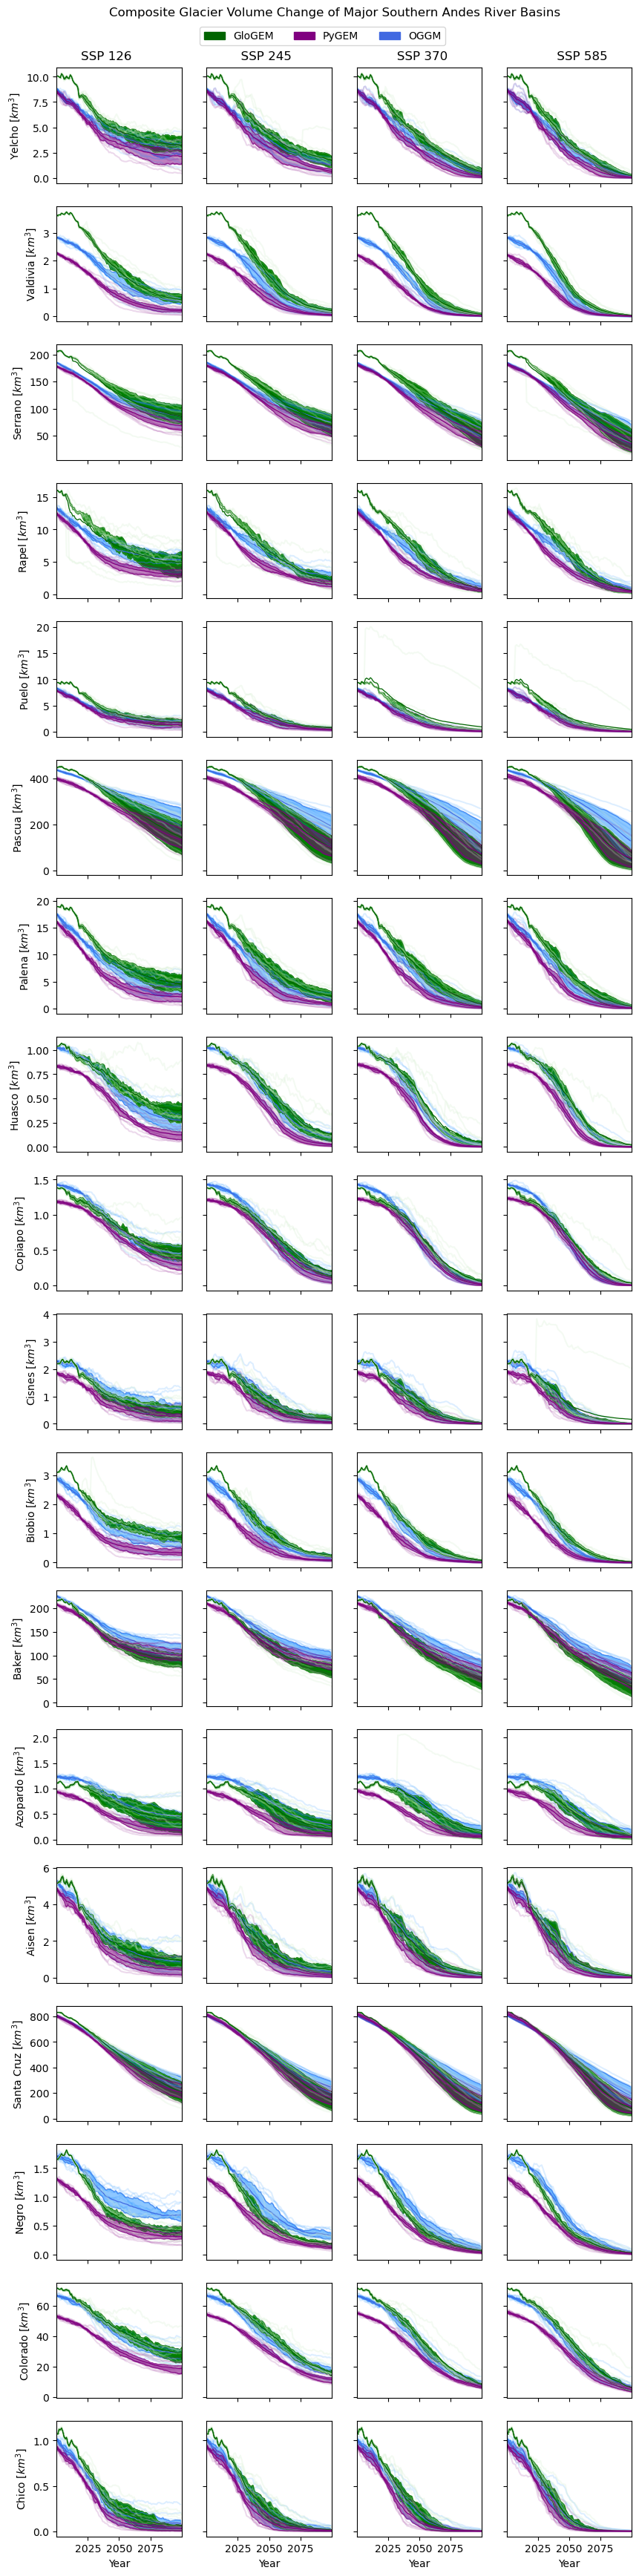

In [22]:
#Plotting all data
fig, axs = plt.subplots(len(basins), len(SSPs), figsize=(10, 2.4*len(basins)), sharex=True)

for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):

        #OG won't plot with built-in ds.plot()
        #Trim last value as it goes to zero
        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[20:-1], trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)

        for m in modelnames_glo:
            axs[b, s].plot(yrs_glo_dt[20::], basin_sums_glo[which_ssp][basin][m][20::], color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.25)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_mean_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q3_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], GCM_q3_glo[which_ssp][basin][20::], color = 'green')
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        for m, model in enumerate(modelnames_py):
            axs[b,s].plot(yrs_glo_dt[20::], basin_sums_py[which_ssp][basin].sel(model = m+1)[0:-1], color = 'purple', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_mean_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', alpha = 0.5)

       
        #Setting x and y labels and making y limits uniform within basins
        if b == (len(basins)-1):
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2025'),pd.to_datetime('2050'), pd.to_datetime('2075')], [2025, 2050, 2075])
        else:
            axs[b, s].set_xlabel(None) 
        
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(len(basins)):
                axs[sub_b,s].set_ylabel(basinstext[sub_b]+ r' $[km^3]$')
        if s != 0:
            axs[b, s].set_ylabel(None)
            axs[b, s].set_yticklabels('')

for b in range(len(basins)):         
    row_min = np.inf
    row_max = -np.inf                 
    for s in range(len(SSPs)):
        data_min = np.min(axs[b, s].get_ybound()[0])
        data_max = np.max(axs[b, s].get_ybound()[1])
        if data_min < row_min:
            row_min = data_min
        if data_max > row_max:
            row_max = data_max
            #row_max[basin] = data_max
    for s in range(len(SSPs)):
        axs[b, s].set_ylim(row_min, row_max)

#Adding in text of # of glaciers in each basin
row_max_values = []
for b, basin in enumerate(basins):
    row_max = max(axs[b, s].get_ylim()[1] for s in range(len(SSPs)))
    row_max_values.append(row_max)

# for s, SSP in enumerate(scenarios):
#     for b, basin in enumerate(basins):
#         y_coord = row_max_values[b] * 0.9
#         axs[b,s].text(pd.to_datetime('2037-01-01'), y_coord,  f"# glaciers = {num_glac_in_basin_glo[basin]}", fontsize=8)
        #axs[b,s].text(pd.to_datetime('2040-01-01'), y_coord,  f"# glaciers = {num_glac_in_basin_OG[basin]}", fontsize=8)
        #axs[b,s].text(pd.to_datetime('2040-01-01'), y_coord,  f"# glaciers = {num_glac_in_basin_py[basin]['ssp126']}", fontsize=8)
       
green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.4), ncol=3)

plt.suptitle('Composite Glacier Volume Change of Major Southern Andes River Basins', x=0.5, y=0.899)
plt.title('SSP 126                            SSP 245                           SSP 370                            SSP 585', x=-1.3, y=(1.19* len(basins))) 

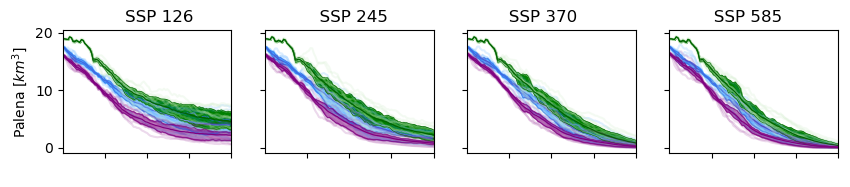

In [23]:
# Input a single basin name
basin = 'PALENA'
basinstext = 'Palena'

# Create a 1-row, 4-column subplot arrangement
fig, axs = plt.subplots(1, 4, figsize=(10, 1.6), sharex=True)

for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    #OG won't plot with built-in ds.plot()
    #Trim last value as it goes to zero
    for m, model in enumerate(modelnames_OG_trimmed):
        axs[s].plot(yrs_glo_dt[20:-1], trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
    axs[s].plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)
    axs[s].plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
    axs[s].plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
    axs[s].fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)

    for m in modelnames_glo:
        axs[s].plot(yrs_glo_dt[20::], basin_sums_glo[which_ssp][basin][m][20::], color=axs[s].set_prop_cycle(glo_cycler), alpha = 0.25)
    axs[s].plot(yrs_glo_dt[20::], GCM_mean_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.9)
    axs[s].plot(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
    axs[s].plot(yrs_glo_dt[20::], GCM_q3_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
    axs[s].fill_between(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], GCM_q3_glo[which_ssp][basin][20::], color = 'green')
    axs[s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

    for m, model in enumerate(modelnames_py):
        axs[s].plot(yrs_glo_dt[20::], basin_sums_py[which_ssp][basin].sel(model = m+1)[0:-1], color = 'purple', alpha = 0.15)
    axs[s].plot(yrs_glo_dt[20::], GCM_mean_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.9)
    axs[s].plot(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
    axs[s].plot(yrs_glo_dt[20::], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
    axs[s].fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', alpha = 0.5)
        # Setting x and y labels
        #axs[s].set_xlabel('Year')
    axs[s].set_xticks([pd.to_datetime('2025'), pd.to_datetime('2050'), pd.to_datetime('2075'), pd.to_datetime('2100')], [' ', ' ', ' ', ' '])

         #axs[s].set_xlabel('Year')
        #axs[s].set_xticks([pd.to_datetime('2025-01-01'), pd.to_datetime('2050-01-01'), pd.to_datetime('2075-01-01'), pd.to_datetime('2100-01-01')])
        #axs[s].set_xticks([pd.to_datetime('2025'), pd.to_datetime('2050'), pd.to_datetime('2075'), pd.to_datetime('2100')])


    # Setting y limits uniform within basins
    if s == 0:
        axs[s].set_ylabel(basinstext + r' $[km^3]$')
    else:
        axs[s].set_ylabel(None)
        axs[s].set_yticklabels('')

# Limits determined by max/min between all GCMs
row_min = np.inf
row_max = -np.inf
for s in range(len(scenarios)):
    data_min = np.min(axs[s].get_ybound()[0])
    data_max = np.max(axs[s].get_ybound()[1])
    if data_min < row_min:
        row_min = data_min
    if data_max > row_max:
        row_max = data_max

for s in range(len(scenarios)):
    axs[s].set_ylim(row_min, row_max)

# Legend
green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM')
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
#axs[0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.2), ncol=3)

# Titles
#plt.suptitle(f'{basin} Runoff Projections for Major Southern Andes River Basins', x=0.5, y=0.9)
plt.title('SSP 126                        SSP 245                       SSP 370                          SSP 585', x=-1.28, y=1)
# Show the plot
name = basinstext
plt.savefig(f"/Users/finnwimberly/Desktop/Lizz Research/AGU Figures/{name}.png", dpi=300, bbox_inches='tight')


plt.show()

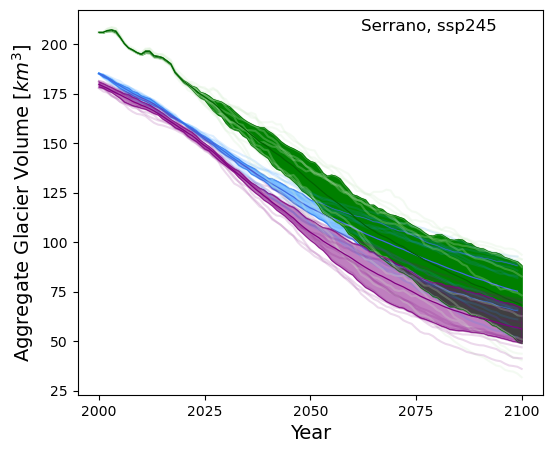

In [48]:
# Input a single basin name
basin = 'SERRANO'
basinstext = 'Serrano'

# Create a 1-row, 4-column subplot arrangement
fig, ax = plt.subplots(figsize=(6, 5))
which_ssp = 'ssp245'

for m, model in enumerate(modelnames_OG_trimmed):
    plt.plot(yrs_glo_dt[20:-1], trimmed_basin_sums_OG[which_ssp][basin][:,0:-1].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
plt.plot(yrs_glo_dt[20:-1], GCM_mean_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.9)
plt.plot(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
plt.plot(yrs_glo_dt[20:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'royalblue', linewidth = 0.4)
plt.fill_between(yrs_glo_dt[20:-1], GCM_q1_OG[which_ssp][basin][0:-1], GCM_q3_OG[which_ssp][basin][0:-1], color = 'dodgerblue', alpha = 0.5)

for m in modelnames_glo:
    plt.plot(yrs_glo_dt[20::], basin_sums_glo[which_ssp][basin][m][20::], color=plt.gca().set_prop_cycle(glo_cycler), alpha = 0.25)
plt.plot(yrs_glo_dt[20::], GCM_mean_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.9)
plt.plot(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
plt.plot(yrs_glo_dt[20::], GCM_q3_glo[which_ssp][basin][20::], color = 'darkgreen', linewidth = 0.4)
plt.fill_between(yrs_glo_dt[20::], GCM_q1_glo[which_ssp][basin][20::], GCM_q3_glo[which_ssp][basin][20::], color = 'green')
#plt.set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

for m, model in enumerate(modelnames_py):
    plt.plot(yrs_glo_dt[20::], basin_sums_py[which_ssp][basin].sel(model = m+1)[0:-1], color = 'purple', alpha = 0.15)
plt.plot(yrs_glo_dt[20::], GCM_mean_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.9)
plt.plot(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
plt.plot(yrs_glo_dt[20::], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
plt.fill_between(yrs_glo_dt[20::], GCM_q1_py[which_ssp][basin][0:-1], GCM_q3_py[which_ssp][basin][0:-1], color = 'purple', alpha = 0.5)
    # Setting x and y labels
    #axs[s].set_xlabel('Year')
plt.xticks([pd.to_datetime('2000'),pd.to_datetime('2025'), pd.to_datetime('2050'), pd.to_datetime('2075'), pd.to_datetime('2100')],
           ['2000','2025', '2050', '2075', '2100'])
    
    # Setting y limits uniform within basins
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Aggregate Glacier Volume ' +  r'$[km^3]$', fontsize = 14)
plt.text(pd.to_datetime('2062'), 207, f"{basinstext}, {which_ssp}", fontsize = 12)
#plt.text(pd.to_datetime('2074'), 185, 'SSP 245', fontsize = 12)



# # Limits determined by max/min between all GCMs
# row_min = np.inf
# row_max = -np.inf

# data_min = np.min(plt.get_ybound()[0])
# data_max = np.max(plt.get_ybound()[1])
# if data_min < row_min:
#     row_min = data_min
# if data_max > row_max:
#     row_max = data_max

#plt.ylim(0, 220)

# Legend
green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM')
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
#axs[0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.2), ncol=3)

# Titles
#plt.suptitle(f'{basin} Runoff Projections for Major Southern Andes River Basins', x=0.5, y=0.9)
#plt.title('SSP 126                        SSP 245                       SSP 370                          SSP 585', x=-1.28, y=1)
# Show the plot
name = basinstext
plt.savefig(f"/Users/finnwimberly/Desktop/Lizz Research/Paper Figs/{name}_Volume.png", dpi=300, bbox_inches='tight')


plt.show()

### Runoff from volume change

In [ ]:
#Change in volume = runoff so:
glacial_melt_glo = {}
glacial_melt_OG = {}
glacial_melt_py = {}
for s, SSP in enumerate(SSPs):
    glacial_melt_glo[SSP] = {}
    glacial_melt_OG[SSP] = {}
    glacial_melt_py[SSP] = {}
    for b, basin in enumerate(basins):
        glacial_melt_glo[SSP][basin] = {}                                       #Converting neg volume change to pos runoff
        for m, model in enumerate(modelnames_glo):                              #And ice volume to water volume
            glacial_melt_glo[SSP][basin][model] = basin_sums_glo[SSP][basin][model][20::].diff()*-0.92
        glacial_melt_OG[SSP][basin] = trimmed_basin_sums_OG[SSP][basin].diff(dim = 'time')*-0.92
        glacial_melt_py[SSP][basin] = basin_sums_py[SSP][basin].diff(dim = 'year')*-0.92

In [ ]:
#Computing multi-GCM means and quartiles
GCM_mean_glacial_melt_OG = {}
GCM_q1_glacial_melt_OG = {}                         #OGGM
GCM_q3_glacial_melt_OG = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_glacial_melt_OG[SSP] = {}
    GCM_q1_glacial_melt_OG[SSP] = {}
    GCM_q3_glacial_melt_OG[SSP] = {}
    for basin in basins:
        GCM_mean_glacial_melt_OG[SSP][basin] = glacial_melt_OG[SSP][basin].mean(dim = 'gcm')
        GCM_q1_glacial_melt_OG[SSP][basin] = glacial_melt_OG[SSP][basin].quantile(q = 0.25, dim = 'gcm')
        GCM_q3_glacial_melt_OG[SSP][basin] = glacial_melt_OG[SSP][basin].quantile(q = 0.75, dim = 'gcm')

GCM_mean_glacial_melt_py = {}
GCM_q1_glacial_melt_py = {}
GCM_q3_glacial_melt_py = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_glacial_melt_py[SSP] = {}
    GCM_q1_glacial_melt_py[SSP] = {}                #PyGEM
    GCM_q3_glacial_melt_py[SSP] = {}
    for basin in basins:
        GCM_mean_glacial_melt_py[SSP][basin] = glacial_melt_py[SSP][basin].mean(dim = 'model')
        GCM_q1_glacial_melt_py[SSP][basin] = glacial_melt_py[SSP][basin].quantile(q = 0.25, dim = 'model')
        GCM_q3_glacial_melt_py[SSP][basin] = glacial_melt_py[SSP][basin].quantile(q = 0.75, dim = 'model')

GCM_mean_glacial_melt_glo = {}
GCM_q1_glacial_melt_glo = {}
GCM_q3_glacial_melt_glo = {}
for s, SSP in enumerate(SSPs):
    GCM_mean_glacial_melt_glo[SSP] = {}
    GCM_q1_glacial_melt_glo[SSP] = {}
    GCM_q3_glacial_melt_glo[SSP] = {}
    for b, basin in enumerate(basins):
        GCM_mean_glacial_melt_glo[SSP][basin] = pd.DataFrame(glacial_melt_glo[SSP][basin]).mean(axis=1)
        GCM_q1_glacial_melt_glo[SSP][basin] = pd.DataFrame(glacial_melt_glo[SSP][basin]).quantile(q=0.25, axis=1)
        GCM_q3_glacial_melt_glo[SSP][basin] = pd.DataFrame(glacial_melt_glo[SSP][basin]).quantile(q=0.75, axis=1)

In [ ]:
#Plotting all data
fig, axs = plt.subplots(len(basins), len(SSPs), figsize=(10, 2.4*len(basins)), sharex=True)
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):
        
        for m in modelnames_glo:
            axs[b, s].plot(yrs_glo_dt[20::], glacial_melt_glo[which_ssp][basin][m], color=axs[b, s].set_prop_cycle(glo_cycler), alpha = 0.9)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_mean_glacial_melt_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q1_glacial_melt_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20::], GCM_q3_glacial_melt_glo[which_ssp][basin], color = 'darkgreen', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20::], GCM_q1_glacial_melt_glo[which_ssp][basin], GCM_q3_glacial_melt_glo[which_ssp][basin], color = 'green')
        axs[b, s].set(xlim=(pd.to_datetime('2000-01-01'), pd.to_datetime('2100-01-01')))

        for m, model in enumerate(modelnames_py):
            axs[b,s].plot(yrs_glo_dt[20:-1], glacial_melt_py[which_ssp][basin].sel(model = m+1)[0:-1], color = 'purple', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_glacial_melt_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_glacial_melt_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_glacial_melt_py[which_ssp][basin][0:-1], color = 'purple', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20:-1], GCM_q1_glacial_melt_py[which_ssp][basin][0:-1], GCM_q3_glacial_melt_py[which_ssp][basin][0:-1], color = 'purple', alpha = 0.2)

        for m, model in enumerate(modelnames_OG_trimmed):
            axs[b,s].plot(yrs_glo_dt[20:-1], glacial_melt_OG[which_ssp][basin].sel(gcm = modelnames_OG_trimmed[m]), color = 'dodgerblue', alpha = 0.15)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_mean_glacial_melt_OG[which_ssp][basin], color = 'royalblue', linewidth = 0.9)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q1_glacial_melt_OG[which_ssp][basin], color = 'royalblue', linewidth = 0.4)
        axs[b,s].plot(yrs_glo_dt[20:-1], GCM_q3_glacial_melt_OG[which_ssp][basin], color = 'royalblue', linewidth = 0.4)
        axs[b,s].fill_between(yrs_glo_dt[20:-1],  GCM_q1_glacial_melt_OG[which_ssp][basin],  GCM_q3_glacial_melt_OG[which_ssp][basin], color = 'dodgerblue', alpha = 0.25)
        
        #Setting x and y labels and making y limits uniform within basins
        if b == (len(basins)-1):
            for sub_s in range(4):  # Use a different variable name for the inner loop
                axs[b, sub_s].set_xlabel('Year')
                axs[b, sub_s].set_xticks([pd.to_datetime('2025'),pd.to_datetime('2050'), pd.to_datetime('2075')], [2025, 2050, 2075])
        else:
            axs[b, s].set_xlabel(None) 
        
        if s == 0:                                                                    #Setting basin labels
            for sub_b in range(len(basins)):
                axs[sub_b,s].set_ylabel(basinstext[sub_b]+ r' $[km^3]$')
        if s != 0:
            axs[b, s].set_ylabel(None)
            axs[b, s].set_yticklabels('')

# for b in range(len(basins)):    #To look more closely at inter-quartile range 
#     row_max = -np.inf
#     row_min = np.inf
#     data_list = []
#     for s in range(len(SSPs)):
#         data = np.concatenate([GCM_q3_glacial_melt_py[SSPs[s]][basins[b]][0:-1], GCM_q3_glacial_melt_glo[SSPs[s]][basins[b]], GCM_q3_glacial_melt_OG[SSPs[s]][basins[b]]])
#         data_list.extend(data[~np.isnan(data) & np.isfinite(data)])
#     if len(data_list) > 0:
#         row_max = np.max(data_list)
#         row_min = np.min(data_list)
#     if row_min >= 0:
#         bottom_limit = row_min / 3
#     else:
#         bottom_limit = row_min * 3
#     for s in range(len(SSPs)):
#         axs[b, s].set_ylim(bottom_limit, row_max)


for b in range(len(basins)):         #To looks at whole picture-limits determined by max/min between all GCMs
    row_min = np.inf
    row_max = -np.inf
    for s in range(len(SSPs)):
        data_min = np.min(axs[b, s].get_ybound()[0])
        data_max = np.max(axs[b, s].get_ybound()[1])
        if data_min < row_min:
            row_min = data_min
        if data_max > row_max:
            row_max = data_max
    for s in range(len(SSPs)):
        axs[b, s].set_ylim(row_min, row_max)

green_patch = mpatches.Patch(color='darkgreen', label='GloGEM')
purple_patch = mpatches.Patch(color='purple', label='PyGEM') 
blue_patch = mpatches.Patch(color='royalblue', label='OGGM')
axs[0,0].legend(handles=[green_patch, purple_patch, blue_patch], bbox_to_anchor=(3.15, 1.4), ncol=3)

plt.suptitle('Runoff from Glacial Melt in Major Southern Andes River Basins', x=0.5, y=0.899)
plt.title('SSP 126                            SSP 245                           SSP 370                            SSP 585', x=-1.3, y=(1.19* len(basins))) 

### CSV Readout
Going to use initial glacial volume in analysis.

In [ ]:
modelnames_all = ['BCC-CSM2-MR','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0', 'NorESM2-MM']

out_df = {}

for s, SSP in enumerate(scenarios):
    out_df[SSP] = {}

    for m, GCM in enumerate(modelnames_all):
        basin_data = {}  # Store data for each basin
        for b, basin in enumerate(basins):
            glo_values = basin_sums_glo[SSP][basin][GCM][20]
            pygem_values = basin_sums_py[SSP][basin].sel(model=m + 1)[0].values
            oggm_values = trimmed_basin_sums_OG[SSP][basin].sel(gcm=modelnames_all[m])[0].values

            # Create a dictionary with values for the current basin
            data = {
                'GloGEM': [glo_values],  # Wrap scalar values in a list
                'OGGM': [oggm_values],
                'PyGEM': [pygem_values],
            }

            # Create a DataFrame for the current basin
            basin_df = pd.DataFrame(data)
            basin_df.index = [basin]  # Set the index as 'Basin' and wrap it in a list

            # Store the basin's DataFrame in the basin_data dictionary
            basin_data[basin] = basin_df

        # Concatenate all basin DataFrames into a single DataFrame for this model and scenario
        out_df[SSP][GCM] = pd.concat(basin_data.values(), axis=0)
        out_df[SSP][GCM].index.name = 'Basin'  # Set the index name

In [ ]:
# Define the directory to save the CSV files
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Volume/RGI 17/'

for SSP in out_df:
    for GCM in out_df[SSP]:
        fname = f"InitialVolume{GCM}_{SSP}.csv"

        # Define the full path of the output file
        output_path = os.path.join(output_dir, fname)

        # Save the DataFrame as CSV
        out_df[SSP][GCM].to_csv(output_path, header=True, index=True)

#### Saving Volume Loss Data:

In [ ]:
scenarios = ['ssp126','ssp245','ssp370','ssp585']

basins = ['YELCHO', 'VALDIVIA', 'SERRANO','RAPEL','PUELO', 'PASCUA', 'PALENA', 'HUASCO', 'COPIAPO', 
          'CISNES', 'BIOBIO', 'BAKER', 'AZOPARDO', 'AISEN', 'SANTA CRUZ', 'NEGRO', 'COLORADO', 'CHICO']

modelnames = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 
                  'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

gmodels = ['GloGEM', 'PyGEM', 'OGGM']

volume_loss = {}
initial_volume = {}
for g, gmodel in enumerate(gmodels):
    volume_loss[gmodel] = {}
    initial_volume[gmodel] = {}
    for s, SSP in enumerate(scenarios):
        volume_loss[gmodel][SSP] = {}
        initial_volume[gmodel][SSP] = {}
        for b, basin in enumerate(basins):
            volume_loss[gmodel][SSP][basin] = {}
            initial_volume[gmodel][SSP][basin] = {}
            for m, GCM in enumerate(modelnames):
                if gmodel == 'GloGEM':
                    volume_loss[gmodel][SSP][basin][GCM] = basin_sums_glo[SSP][basin][GCM][20] - basin_sums_glo[SSP][basin][GCM][-1]
                    initial_volume[gmodel][SSP][basin][GCM] = basin_sums_glo[SSP][basin][GCM][20]
                if gmodel == 'OGGM':
                    volume_loss[gmodel][SSP][basin][GCM] = float(trimmed_basin_sums_OG[SSP][basin].sel(gcm = GCM)[0] - trimmed_basin_sums_OG[SSP][basin].sel(gcm = GCM)[-1])
                    initial_volume[gmodel][SSP][basin][GCM] = float(trimmed_basin_sums_OG[SSP][basin].sel(gcm = GCM)[0])
                if gmodel == 'PyGEM':
                    volume_loss[gmodel][SSP][basin][GCM] = float(basin_sums_py[SSP][basin].sel(model = m+1)[0]- basin_sums_py[SSP][basin].sel(model = m+1)[-2])
                    initial_volume[gmodel][SSP][basin][GCM] = float(basin_sums_py[SSP][basin].sel(model = m+1)[0])

In [ ]:
# Initialize a dictionary to store the DataFrames for each SSP and GCM combination
volume_loss_dfs = {}
initial_volume_dfs = {}

# Loop through SSP scenarios
for SSP in scenarios:
    # Loop through GCMs
    for GCM in modelnames:
        # Initialize DataFrames for volume loss and initial volume
        volume_loss_df = pd.DataFrame(index=basins)
        initial_volume_df = pd.DataFrame(index=basins)

        # Loop through the glacier models
        for gmodel in gmodels:
            # Create columns for each model with volume loss and initial volume
            volume_loss_df[gmodel] = [volume_loss[gmodel][SSP][basin][GCM] for basin in basins]
            initial_volume_df[gmodel] = [initial_volume[gmodel][SSP][basin][GCM] for basin in basins]

        # Store the DataFrames in the dictionary with the SSP and GCM as keys
        volume_loss_dfs[f"{SSP}_{GCM}"] = volume_loss_df
        initial_volume_dfs[f"{SSP}_{GCM}"] = initial_volume_df

In [ ]:
initial_volume_dfs['ssp126_CESM2']

In [ ]:
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Parameters/Regional Imports/Volume Loss/'

for key in volume_loss_dfs:
    fname = f"Volume_Loss-RGI-17{key}.csv"

    # Define the full path of the output file
    output_path = os.path.join(output_dir, fname)

    # Save the DataFrame as CSV
    volume_loss_dfs[key].to_csv(output_path, header=True, index=True)

In [ ]:
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Parameters/Regional Imports/Initial Volume/'

for key in initial_volume_dfs:
    fname = f"Initial_Volume-RGI-17{key}.csv"

    # Define the full path of the output file
    output_path = os.path.join(output_dir, fname)

    # Save the DataFrame as CSV
    initial_volume_dfs[key].to_csv(output_path, header=True, index=True)

GCM mean:

In [ ]:
mean_volume_loss = {}
mean_initial_volume = {}
for g, gmodel in enumerate(gmodels):
    mean_volume_loss[gmodel] = {}
    mean_initial_volume[gmodel] = {}
    for s, SSP in enumerate(scenarios):
        mean_volume_loss[gmodel][SSP] = {}
        mean_initial_volume[gmodel][SSP] = {}
        for b, basin in enumerate(basins):
            if gmodel == 'GloGEM':
                mean_volume_loss[gmodel][SSP][basin] = GCM_mean_glo[SSP][basin][20] - GCM_mean_glo[SSP][basin][-1]
                mean_initial_volume[gmodel][SSP][basin] = GCM_mean_glo[SSP][basin][20]
            if gmodel == 'OGGM':
                mean_volume_loss[gmodel][SSP][basin] = float(GCM_mean_OG[SSP][basin][0] - GCM_mean_OG[SSP][basin][-1])
                mean_initial_volume[gmodel][SSP][basin] = float(GCM_mean_OG[SSP][basin][0])
            if gmodel == 'PyGEM':
                mean_volume_loss[gmodel][SSP][basin] = float(GCM_mean_py[SSP][basin][0]- GCM_mean_py[SSP][basin][-2])
                mean_initial_volume[gmodel][SSP][basin] = float(GCM_mean_py[SSP][basin][0])

In [ ]:
# Initialize dictionaries to store the DataFrames for each SSP and GCM combination
mean_volume_loss_dfs = {}
mean_initial_volume_dfs = {}

# Loop through SSP scenarios
for SSP in scenarios:
    # Initialize DataFrames for volume loss and initial volume
    mean_volume_loss_df = pd.DataFrame(index=basins)
    mean_initial_volume_df = pd.DataFrame(index=basins)

    # Loop through the glacier models
    for gmodel in gmodels:
        # Create columns for each model with volume loss and initial volume
        mean_volume_loss_df[gmodel] = [mean_volume_loss[gmodel][SSP][basin] for basin in basins]
        mean_initial_volume_df[gmodel] = [mean_initial_volume[gmodel][SSP][basin] for basin in basins]

    # Store the DataFrames in the dictionary with the SSP as the key
    mean_volume_loss_dfs[SSP] = mean_volume_loss_df
    mean_initial_volume_dfs[SSP] = mean_initial_volume_df

In [ ]:
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Parameters/Regional Imports/Mean Volumes/'

for SSP in scenarios:
    fname = f"Mean_Volume_Loss-RGI-17_{SSP}.csv"

    # Define the full path of the output file
    output_path = os.path.join(output_dir, fname)

    # Save the DataFrame as CSV
    mean_volume_loss_dfs[SSP].to_csv(output_path, header=True, index=True)

In [ ]:
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Parameters/Regional Imports/Mean Volumes/'

for SSP in scenarios:
    fname = f"Mean_Initial_Volume-RGI-17{SSP}.csv"

    # Define the full path of the output file
    output_path = os.path.join(output_dir, fname)

    # Save the DataFrame as CSV
    mean_initial_volume_dfs[SSP].to_csv(output_path, header=True, index=True)

#### And number of glaciers:

In [ ]:
def get_glac_list(basin_RGI_list, volume_data):
    # Create new list to match our RGI formatting
    new_basin_list = [str(x)[-8:] for x in basin_RGI_list]
    #runoff_data = runoff_data.transpose()
    
    #TODO: create list of glaciers within a basin that are not included in GloGEM output
    # Filter new_basin_list to keep only the indexes present in the DataFrame
    new_basin_list = [x for x in new_basin_list if x in volume_data.index]
    
    # Extract glaciers contained in the list from original df and create a new df
    new_df = volume_data.loc[new_basin_list].copy()

    glac_list = new_df.index.tolist()
    
    number_glac = len(glac_list)
    
    # Sum the values of the glaciers within the basin
    #summed_basin_runoff = new_df.sum()
    #print(summed_basin_runoff)
    
    return glac_list#, number_glac

In [ ]:
#making lists of all glaciers in each basin for each model AND counting the totals
glac_list = {}
number_glac = {}
for g, gmodel in enumerate(gmodels):
    glac_list[gmodel] = {}
    number_glac[gmodel] = {}
    for b, basin in enumerate(Alpine_basins):
        if gmodel == 'GloGEM':
            glac_list[gmodel][basin] = get_glac_list(select_glaciers_json(Alpine_basins[basin]), volumes[SSP][model])
            number_glac[gmodel][basin] = len(glac_list[gmodel][basin])
        if gmodel == 'OGGM':
            glac_list[gmodel][basin] = vol_ds[basin].coords['rgi_id'].values.tolist()
            glac_list['OGGM'][basin] = [rgi_id[-8:] for rgi_id in glac_list['OGGM'][basin]]
            number_glac[gmodel][basin] = len(glac_list[gmodel][basin])
        if gmodel == 'PyGEM':    
            glac_list[gmodel][basin] = basin_volumes[basin]['ssp126'].coords['RGIId'].values.tolist()
            glac_list['PyGEM'][basin] = [rgi_id[-8:] for rgi_id in glac_list['PyGEM'][basin]]
            number_glac[gmodel][basin] = len(glac_list[gmodel][basin])

In [ ]:
number_glac[gmodel]

In [ ]:
# Initialize an empty list to store DataFrames
dfs = []

for gmodel in gmodels:
    for basin in Alpine_basins:
        # Calculate the number of glaciers for each model and basin
        if gmodel == 'GloGEM':
            number_of_glaciers = len(glac_list[gmodel][basin])
        elif gmodel == 'OGGM':
            number_of_glaciers = len(glac_list[gmodel][basin])
        elif gmodel == 'PyGEM':
            number_of_glaciers = len(glac_list[gmodel][basin])

        # Create a DataFrame for each combination
        df = pd.DataFrame({
            'Model': gmodel,
            'Basin': basin,
            'Number_of_Glaciers': [number_of_glaciers]
        })
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
number_glaciers = pd.concat(dfs, ignore_index=True)
# Pivot the DataFrame to have the basin names as row indexes and model names as column headers
number_glaciers = number_glaciers.pivot(index='Basin', columns='Model', values='Number_of_Glaciers')

In [ ]:
number_glaciers

In [ ]:
output_dir = '/Users/finnwimberly/Desktop/Lizz Research/CSV Outputs/Parameters/Regional Imports/Number of Glaciers/'

fname = "#glaciers-RGI-17.csv"

# Define the full path of the output file
output_path = os.path.join(output_dir, fname)

# Save the DataFrame as CSV
number_glaciers.to_csv(output_path, header=True, index=True)

In [ ]:
def find_unique_elements(list1, list2):
    # Convert the lists to sets for efficient comparison
    set1 = set(list1)
    set2 = set(list2)

    # Find elements that are in set1 but not in set2
    unique_in_list1 = list(set1 - set2)

    # Find elements that are in set2 but not in set1
    unique_in_list2 = list(set2 - set1)

    return unique_in_list1, unique_in_list2

In [ ]:
missing_glaciers = {}
for b, basin in enumerate(Alpine_basins):
    not_in_oggm, not_in_glo = find_unique_elements(glac_list['GloGEM'][basin], glac_list['OGGM'][basin])

    not_in_py = find_unique_elements(glac_list['PyGEM'][basin], glac_list['OGGM'][basin])[1]
    
    # If both not_in_oggm and not_in_py are empty, set not_in_glo equal to not_in_oggm
    if not not_in_oggm and not not_in_py:
        not_in_py = not_in_oggm

    # Store the results in the dictionary for this basin
    missing_glaciers[basin] = {
        'Basin': basin,
        'GloGEM': not_in_glo,
        'OGGM': not_in_oggm,
        'PyGEM': not_in_py
    }

# Concatenate the dictionaries into a single DataFrame
missing_glaciers_df = pd.DataFrame(missing_glaciers).T.reset_index(drop=True)

In [ ]:
missing_glaciers_df